# Import

In [1]:
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import html
import re
import logging
import os
import requests

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# Chroma
import chromadb 
from chromadb.utils import embedding_functions
from langchain.vectorstores import Chroma

# Sentence Transformers
from sentence_transformers import SentenceTransformer

C:\Users\Nathan\anaconda3\envs\Html_embeddings\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize logging
logging.basicConfig(level=logging.INFO)

# Set up 

In [3]:
# Configuration
config = {
    'site1': {
        'index_path': "http://192.168.48.22:8082/repository/skyminer-dev/skyminer-documentation/latest/administration-manual-html/administration-manual-html/index.html",
        'base_path': "http://192.168.48.22:8082/repository/skyminer-dev/skyminer-documentation/latest/administration-manual-html/administration-manual-html/",
        'documentation': 'administration-manual'
    },
    'site2': {
        'index_path': "http://192.168.48.22:8082/repository/skyminer-dev/skyminer-documentation/latest/user-manual-html/user-manual-html/index.html",
        'base_path': "http://192.168.48.22:8082/repository/skyminer-dev/skyminer-documentation/latest/user-manual-html/user-manual-html/",
        'documentation': 'user-manual'
    }
}

In [4]:
# Function to read the local HTML file
def read_local_html(file_path):
    if not os.path.exists(file_path):
        logging.warning(f"File not found: {file_path}")
        return ''
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

In [5]:
def fetch_html_from_url(url):
    response = requests.get(url)
    response.encoding = 'utf-8'
    response.raise_for_status()
    return response.text

In [6]:
def get_path(html_content, h='h1'):
    html_content.split(f'</{h}>', 0)
    soup = BeautifulSoup(html_content.split(f'</{h}>')[0], 'html.parser')
    h_text = soup.find(f'{h}').text.replace("¶", "").replace("Â", " ")
    return '/' + h_text

In [7]:
def scrape_content_from_page(html_content, source, file_path):
    h1_split = html_content.split('<h1')
    list_split = list()
    list_path = list()
    list_source = list()  # For storing the documentation source
    list_file_path = list()
    path = ''
 
    for i, h1 in enumerate(h1_split):
        if i > 0:
            h1 = '<h1' + h1
            result = path.split('/')[:1] 
            path = '/'.join(result)
            path += get_path(h1, h='h1')      
 
        h2_split = h1.split('<h2')
        for j, h2 in enumerate(h2_split):
            if j > 0:
                h2 = '<h2' + h2
                result = path.split('/')[:2] 
                path = '/'.join(result)
                path += get_path(h2, h='h2')
            h3_split = h2.split('<h3')
            for k, h3 in enumerate(h3_split):
                if k > 0:
                    h3 = '<h3' + h3
                    result = path.split('/')[:3] 
                    path = '/'.join(result)
                    path += get_path(h3, h='h3')
 
                h4_split = h3.split('<h4')
                for l, h4 in enumerate(h4_split):
                    if l > 0: 
                        h4 = '<h4' + h4
                        result = path.split('/')[:4] 
                        path = '/'.join(result)
                        path += get_path(h4, h='h4')    
 
                    h5_split = h4.split('<h5')
                    # Look for href in the html content to add it to the link
                    regex_pattern = r'<h[1-6](.*?)<\/h[1-6]>'
                    header = re.search(regex_pattern, h5_split[0])
                    if header:
                        regex_pattern = r'href="#([^"]*)"'
                        match_href = re.search(regex_pattern, header.group(1))
                        regex_pattern = r'id="([^"]*)"'
                        match_id = re.search(regex_pattern, header.group(1))
                        if match_href:
                            href = '#' + match_href.group(1)
                        elif match_id:
                            href = '#' + match_id.group(1)
                        else:
                            href = ''
                    else:
                        href = ''
                    # get the text from html content
                    soup = BeautifulSoup(h5_split[0].split('\n', 1)[1], "lxml")
                    h5_split = soup.get_text()
                    list_split.append(h5_split)
                    list_path.append(path)
                    list_source.append(source)  # Add the documentation source for each content
                    list_file_path.append(f'{file_path}{href}')
    df = pd.DataFrame()
    df['documentation'] = list_source  # Add the documentation source column
    df['path'] = list_path
    df['text'] = list_split
    df['file_path'] = list_file_path  # adding local path to the df for each row
    return df

In [8]:
def process_links(site_config):
    index_content = fetch_html_from_url(site_config['index_path'])
    soup = BeautifulSoup(index_content, 'html.parser')
    links = [a['href'] for a in soup.find_all('a', href=True) if a['href'].endswith('.html')]
    
    logging.info(f"Found {len(links)} links to process for {site_config['documentation']}.")
    
    data_frames = []
    for link in links:
        full_url = site_config['base_url'] + link  # Construct the full URL
        try:
            page_content = fetch_html_from_url(full_url)
            df_temp = scrape_content_from_page(page_content, site_config['documentation'], full_url)
            
            # Check if df_temp is not empty or None
            if df_temp is not None and not df_temp.empty:
                data_frames.append(df_temp)
            else:
                logging.warning(f"Empty dataframe returned from {full_url}.")
            
        except Exception as e:
            logging.error(f"Error processing {full_url}: {e}")
    
    logging.info(f"Processed {len(data_frames)} dataframes for {site_config['documentation']}.")
    return data_frames

In [9]:
def process_links_from_list(links, documentation_label):
    logging.info(f"Found {len(links)} links to process for {documentation_label}.")
    
    data_frames = []
    for link in links:
        try:
            page_content = fetch_html_from_url(link)
            df_temp = scrape_content_from_page(page_content, documentation_label, link)
            
            # Check if df_temp is not empty or None
            if df_temp is not None and not df_temp.empty:
                data_frames.append(df_temp)
            else:
                logging.warning(f"Empty dataframe returned from {link}.")
            
        except Exception as e:
            logging.error(f"Error processing {link}: {e}")
    
    logging.info(f"Processed {len(data_frames)} dataframes for {documentation_label}.")
    return data_frames

# Get links

In [10]:
def get_all_links(base_url):
    # Send a GET request to the base URL
    response = requests.get(base_url)
    response.raise_for_status()  # Raise an exception for HTTP errors

    # Parse the content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract all anchor tags
    anchors = soup.find_all('a', href=True)

    # Convert relative URLs and fragments to absolute URLs
    absolute_urls = [urljoin(base_url, a['href']) for a in anchors]

    return absolute_urls

In [11]:
site_urls = [details['index_path'] for details in config.values()]

In [12]:
site_urls

['http://192.168.48.22:8082/repository/skyminer-dev/skyminer-documentation/latest/administration-manual-html/administration-manual-html/index.html',
 'http://192.168.48.22:8082/repository/skyminer-dev/skyminer-documentation/latest/user-manual-html/user-manual-html/index.html']

In [13]:
a_urls = get_all_links(site_urls[0])
u_urls = get_all_links(site_urls[1])

In [14]:
a_urls[1], u_urls[1]

('http://192.168.48.22:8082/repository/skyminer-dev/skyminer-documentation/latest/administration-manual-html/administration-manual-html/index.html',
 'http://192.168.48.22:8082/repository/skyminer-dev/skyminer-documentation/latest/user-manual-html/user-manual-html/index.html')

# Scrape the Content and Store in a DataFrame:

In [15]:
df1 = process_links_from_list(a_urls, "Administrastion Manual")

INFO:root:Found 233 links to process for Administrastion Manual.
INFO:root:Processed 233 dataframes for Administrastion Manual.


In [16]:
df2 = process_links_from_list(u_urls, "User Manual")

INFO:root:Found 100 links to process for User Manual.
INFO:root:Processed 100 dataframes for User Manual.


In [17]:
df1 = pd.concat(df1, ignore_index=True)
df2 = pd.concat(df2, ignore_index=True)

In [18]:
df = pd.concat([df1, df2], ignore_index=True)

In [19]:
df

,documentation,path,text,file_path
0,Administrastion Manual,,\n\nSpace Systems | Kratos\n\n\n\n\n\n\n\n\n\...,http://www.kratoscomms.com/
1,Administrastion Manual,/Leading Space Networks into the Future,\n,http://www.kratoscomms.com/
2,Administrastion Manual,/Revolutionary Satellite Ground Solutions,,http://www.kratoscomms.com/
3,Administrastion Manual,/Revolutionary Satellite Ground Solutions/Guid...,\n,http://www.kratoscomms.com/
4,Administrastion Manual,/Revolutionary Satellite Ground Solutions/Guid...,\nMainstreaming satellite operations to connec...,http://www.kratoscomms.com/
...,...,...,...,...
4004,User Manual,/FAQ/Is the data processed between the source ...,By default there is no process or filter appli...,http://192.168.48.22:8082/repository/skyminer-...
4005,User Manual,/FAQ/How much data can be displayed on Skyminer?,By default there are 3 safeguards for the size...,http://192.168.48.22:8082/repository/skyminer-...
4006,User Manual,/FAQ/How can I export data from Skyminer?,You can export the data to a JSON or CSV file ...,http://192.168.48.22:8082/repository/skyminer-...
4007,User Manual,/FAQ/How do I align time series to time bounda...,Using aggregators: this can be achieved by sel...,http://192.168.48.22:8082/repository/skyminer-...


# Turn to DF

In [20]:
df

,documentation,path,text,file_path
0,Administrastion Manual,,\n\nSpace Systems | Kratos\n\n\n\n\n\n\n\n\n\...,http://www.kratoscomms.com/
1,Administrastion Manual,/Leading Space Networks into the Future,\n,http://www.kratoscomms.com/
2,Administrastion Manual,/Revolutionary Satellite Ground Solutions,,http://www.kratoscomms.com/
3,Administrastion Manual,/Revolutionary Satellite Ground Solutions/Guid...,\n,http://www.kratoscomms.com/
4,Administrastion Manual,/Revolutionary Satellite Ground Solutions/Guid...,\nMainstreaming satellite operations to connec...,http://www.kratoscomms.com/
...,...,...,...,...
4004,User Manual,/FAQ/Is the data processed between the source ...,By default there is no process or filter appli...,http://192.168.48.22:8082/repository/skyminer-...
4005,User Manual,/FAQ/How much data can be displayed on Skyminer?,By default there are 3 safeguards for the size...,http://192.168.48.22:8082/repository/skyminer-...
4006,User Manual,/FAQ/How can I export data from Skyminer?,You can export the data to a JSON or CSV file ...,http://192.168.48.22:8082/repository/skyminer-...
4007,User Manual,/FAQ/How do I align time series to time bounda...,Using aggregators: this can be achieved by sel...,http://192.168.48.22:8082/repository/skyminer-...


In [21]:
df.iloc[0,2]

' \n\nSpace Systems | Kratos\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAboutAboutAbout KratosDivisionsLocations & ContactsUpcoming EventsAbout KratosLeadershipContract VehiclesSmall BusinessEthics & ComplianceCorporate GovernanceContract VehiclesSeaPort-NxGTETRASATS-2Training System Contract IV (TSC IV)USV FoS IDIQ-MACDivisionsUnmanned SystemsSpace, Training and CybersecurityDefense & Rocket Support ServicesMicrowave ElectronicsTurbine TechnologiesC5ISR SystemsUnmanned SystemsSystem IntegrationTrainingTest & ManufacturingSpace, Training and CybersecuritySpaceTrainingCyberTrainingSimulation SystemsTraining ServicesSimulation Training PlatformTraining ServicesAircrew Training CentersCurriculum DevelopmentSustainment ServicesCyberC3PAO ServicesFedRAMP Assessment & Advisory ServicesDoD CC SRG ServicesNIST/RMFPCI DSS Advisory & Assessment ServicesCloud Security StrategyContinuous MonitoringDynamic Advisory ServicesPenetration TestingVulnerability AssessmentsApplic

In [22]:
df.iloc[89,2]

'You can find cassandra documentation online at http://cassandra.apache.org/doc/latest\n\n'

In [23]:
df.iloc[336,2]

'\n'

# Clean data

In [24]:
def clean_text(text):
    # Whitespace normalization
    text = ' '.join(text.split())
    
    # Handling newline characters to create a visual separation
    text = text.replace('\n', ' ')

    # Handle LaTeX math expressions: This step can be enhanced further based on specific needs
    # The idea here is to isolate math expressions so that they don't get affected by other cleaning operations
    math_expressions = re.findall(r'\\\(.*?\\\)', text)
    for math_expr in math_expressions:
        placeholder = math_expr.replace(' ', '_')
        text = text.replace(math_expr, placeholder)

    # Removing unwanted characters like ¶
    text = text.replace('¶', '')

    # Punctuation spacing: Ensure spaces before and after punctuation
    text = re.sub(r'(?<=[\w])([.,;:!?\(\)\[\]])', r' \1', text)
    text = re.sub(r'([.,;:!?\(\)\[\]])(?=[\w])', r'\1 ', text)

    # Replace back the LaTeX math expressions
    for math_expr in math_expressions:
        placeholder = math_expr.replace(' ', '_')
        text = text.replace(placeholder, math_expr)

    
    return text

In [25]:
# Apply this function to the entire 'content' column
df['text'] = df['text'].apply(clean_text)

In [26]:
df['text'].iloc[0]

'Space Systems | Kratos AboutAboutAbout KratosDivisionsLocations & ContactsUpcoming EventsAbout KratosLeadershipContract VehiclesSmall BusinessEthics & ComplianceCorporate GovernanceContract VehiclesSeaPort-NxGTETRASATS-2Training System Contract IV ( TSC IV ) USV FoS IDIQ-MACDivisionsUnmanned SystemsSpace , Training and CybersecurityDefense & Rocket Support ServicesMicrowave ElectronicsTurbine TechnologiesC5ISR SystemsUnmanned SystemsSystem IntegrationTrainingTest & ManufacturingSpace , Training and CybersecuritySpaceTrainingCyberTrainingSimulation SystemsTraining ServicesSimulation Training PlatformTraining ServicesAircrew Training CentersCurriculum DevelopmentSustainment ServicesCyberC3PAO ServicesFedRAMP Assessment & Advisory ServicesDoD CC SRG ServicesNIST/RMFPCI DSS Advisory & Assessment ServicesCloud Security StrategyContinuous MonitoringDynamic Advisory ServicesPenetration TestingVulnerability AssessmentsApplication TestingEnterprise Security ArchitectureFISMAFISMA ReadinessDefe

In [27]:
df['text'].iloc[89]

'You can find cassandra documentation online at http ://cassandra . apache . org/doc/latest'

In [28]:
df['text'].iloc[336]

''

In [29]:
df['text'].iloc[400]

'For a standalone server you will select the following answers : local postgresql database only one Cassandra and OpenSearch node'

# Format size for emebddings

In [30]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

In [31]:
df.iloc[336]

documentation                               Administrastion Manual
path                                           /Data & filesystems
text                                                              
file_path        http://192.168.48.22:8082/repository/skyminer-...
word_count                                                       0
Name: 336, dtype: object

C:\Users\Nathan\anaconda3\envs\Html_embeddings\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nathan\anaconda3\envs\Html_embeddings\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


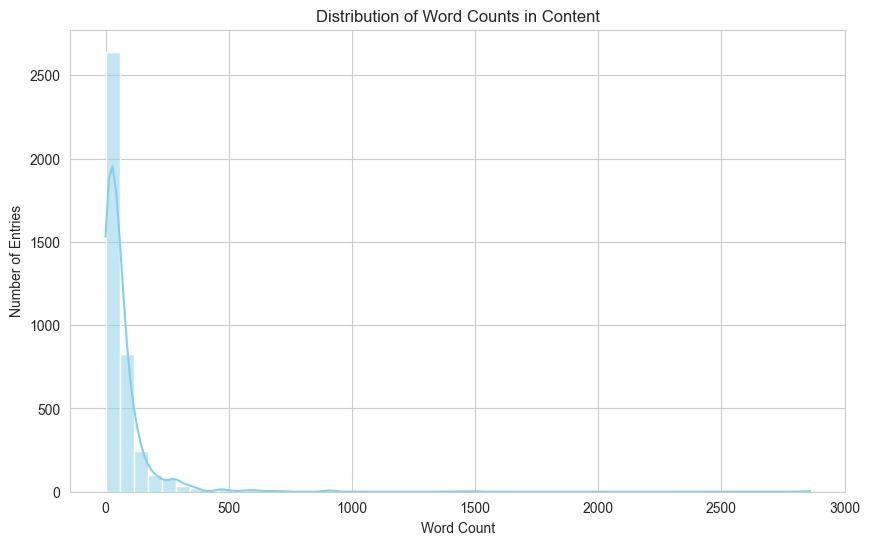

In [32]:
# Set Seaborn style
sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Word Counts in Content')
plt.xlabel('Word Count')
plt.ylabel('Number of Entries')
plt.show()

C:\Users\Nathan\anaconda3\envs\Html_embeddings\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nathan\anaconda3\envs\Html_embeddings\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


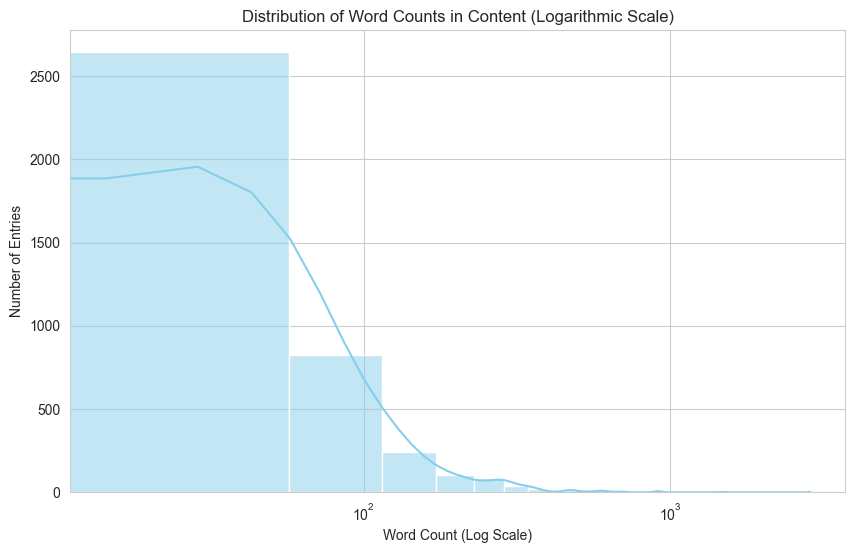

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color='skyblue')
plt.xscale('log')
plt.title('Distribution of Word Counts in Content (Logarithmic Scale)')
plt.xlabel('Word Count (Log Scale)')
plt.ylabel('Number of Entries')
plt.show()

## Remove the empty text

In [34]:
# Remove rows where the text is empty
df = df[df['text'].notnull() & (df['text'].str.len() > 0)]

In [35]:
# Remove rows where the text is empty or the path is an empty string
df = df[(df['path'].notnull()) & (df['path'] != "") & (df['text'].str.len() > 0)]


In [36]:
# Remove rows where path equals "/Table Of Contents"
df = df[df['path'] != '/Table Of Contents']

In [37]:
# Remove duplicates based on the 'text' column
df = df.drop_duplicates(subset='text', keep='first')

In [38]:
# Find rows with duplicate content
duplicates = df[df.duplicated(subset='text', keep=False)]
duplicates

,documentation,path,text,file_path,word_count


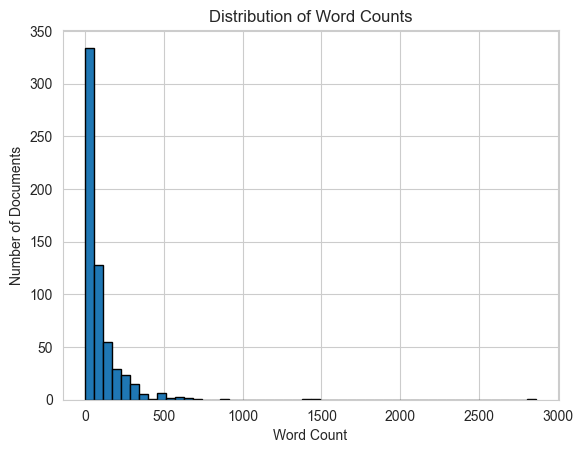

In [39]:
# Add a new column for word counts
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Plot a histogram of word counts
plt.hist(df['word_count'], bins=50, edgecolor='k')
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Number of Documents')
plt.show()


In [40]:
sorted_df = df.sort_values(by='word_count', ascending=False)


# clean

In [41]:
threshold = 20  # or any other value based on your visualization or requirements
smol = df[df['word_count'] < threshold]
final_df = df[df['word_count'] > threshold]


In [42]:
smol

,documentation,path,text,file_path,word_count
4,Administrastion Manual,/Revolutionary Satellite Ground Solutions/Guid...,Mainstreaming satellite operations to connect ...,http://www.kratoscomms.com/,10
5,Administrastion Manual,/Revolutionary Satellite Ground Solutions/Guid...,"Advancing secure , resilient communication cro...",http://www.kratoscomms.com/,9
6,Administrastion Manual,/Revolutionary Satellite Ground Solutions/Guid...,Creating infrastructure and systems to support...,http://www.kratoscomms.com/,10
7,Administrastion Manual,/Technology for the Satellite Ground Ecosystem,Kratos develops advanced satellite communicati...,http://www.kratoscomms.com/,16
8,Administrastion Manual,/Technology for the Satellite Ground Ecosystem...,… helping customers expand their network and m...,http://www.kratoscomms.com/,13
...,...,...,...,...,...
3608,User Manual,/Skyminer extensions/Skyminer WEBUI integratio...,The address of the server is saved in a variab...,http://192.168.48.22:8082/repository/skyminer-...,12
3645,User Manual,/Skyminer Time Series Python Connector/Install...,./Scripts/Update . py -u <api_url>,http://192.168.48.22:8082/repository/skyminer-...,5
3654,User Manual,/Skyminer Time Series Python Connector/Modules...,"TR = TimeRelative ( 1 , TimeUnit . MINUTES )",http://192.168.48.22:8082/repository/skyminer-...,10
3655,User Manual,/Skyminer Time Series Python Connector/Modules...,TimeUnit is an enum of the time unit . MILLISE...,http://192.168.48.22:8082/repository/skyminer-...,17


In [43]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nathan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
stop_words = set(stopwords.words('english'))

def stopword_percentage(text):
    if not text or not isinstance(text, str):
        return 0
    
    words = text.split()
    if not words:
        return 0
    
    stopword_count = sum(1 for word in words if word.lower() in stop_words)
    return (stopword_count / len(words)) * 100


In [45]:
smol = smol.copy()  # Making a copy of your DataFrame for this operation
smol['score'] = smol['text'].apply(stopword_percentage)


In [46]:
smol = smol.sort_values(by='score', ascending=False)
smol

,documentation,path,text,file_path,word_count,score
1480,Administrastion Manual,/Throwaway (no storage) datastore/Architecture,Data is NOT stored at all .,http://192.168.48.22:8082/repository/skyminer-...,7,57.142857
3606,User Manual,/Skyminer extensions/Skyminer WEBUI integratio...,The parameters will be in a variable called WE...,http://192.168.48.22:8082/repository/skyminer-...,9,55.555556
1591,Administrastion Manual,/Aggregators/Aggregator Parameters,The following are parameters that are common t...,http://192.168.48.22:8082/repository/skyminer-...,13,53.846154
3608,User Manual,/Skyminer extensions/Skyminer WEBUI integratio...,The address of the server is saved in a variab...,http://192.168.48.22:8082/repository/skyminer-...,12,50.000000
3607,User Manual,/Skyminer extensions/Skyminer WEBUI integratio...,You can use the &sk_reload=1 parameter to reru...,http://192.168.48.22:8082/repository/skyminer-...,16,50.000000
...,...,...,...,...,...,...
1765,Administrastion Manual,/Query Metrics/Request,http ://[ host ]:[ port ]/api/v1/datapoints/qu...,http://192.168.48.22:8082/repository/skyminer-...,10,0.000000
1768,Administrastion Manual,/Query Metrics/Request,http ://[ host ]:[ port ]/api/v1/datapoints/query,http://192.168.48.22:8082/repository/skyminer-...,6,0.000000
1778,Administrastion Manual,/Skyminer Time Series Indexer Module API/Get S...,http ://[ host ]:[ port ]/api/skyminer/ts-inde...,http://192.168.48.22:8082/repository/skyminer-...,6,0.000000
1783,Administrastion Manual,/Skyminer Time Series Indexer Module API/Rebui...,http ://[ host ]:[ port ]/api/skyminer/ts-inde...,http://192.168.48.22:8082/repository/skyminer-...,6,0.000000


C:\Users\Nathan\anaconda3\envs\Html_embeddings\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nathan\anaconda3\envs\Html_embeddings\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


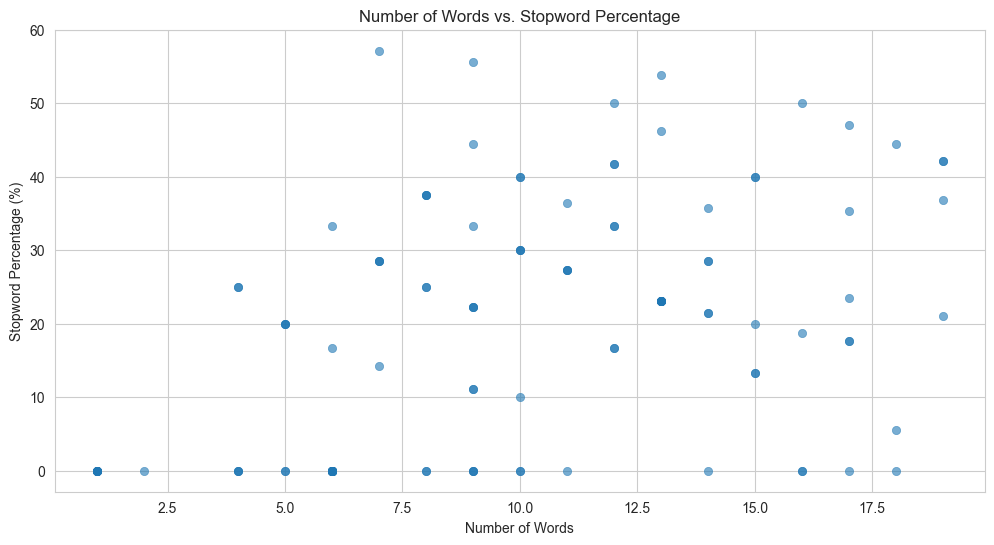

In [47]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=smol, x='word_count', y='score', alpha=0.6, edgecolor=None)

plt.title('Number of Words vs. Stopword Percentage')
plt.xlabel('Number of Words')
plt.ylabel('Stopword Percentage (%)')

plt.show()


# Final preview

In [48]:
final_df

,documentation,path,text,file_path,word_count
9,Administrastion Manual,/Technology for the Satellite Ground Ecosystem...,… including satellite ground apps that can be ...,http://www.kratoscomms.com/,32
10,Administrastion Manual,/Technology for the Satellite Ground Ecosystem...,… supported by Kratos’ global RF sensor networ...,http://www.kratoscomms.com/,31
11,Administrastion Manual,/Technology for the Satellite Ground Ecosystem...,… for an increasingly competitive and conteste...,http://www.kratoscomms.com/,30
15,Administrastion Manual,/Contact Us,"5971 Kingstowne Village Pkwy , Suite 200 Alexa...",http://www.kratoscomms.com/,26
16,Administrastion Manual,/Contact Us/Systems & Platforms,Unmanned Systems Tactical UAVs Small UAS Swarm...,http://www.kratoscomms.com/,32
...,...,...,...,...,...
3659,User Manual,/Skyminer Time Series Python Connector/Modules...,The Bin grouper groups data point values into ...,http://192.168.48.22:8082/repository/skyminer-...,107
3660,User Manual,/Skyminer Time Series Python Connector/Modules...,You can group results by specifying one or mor...,http://192.168.48.22:8082/repository/skyminer-...,83
3661,User Manual,/Skyminer Time Series Python Connector/Modules...,The time grouper groups results by time ranges...,http://192.168.48.22:8082/repository/skyminer-...,150
3662,User Manual,/Skyminer Time Series Python Connector/Modules...,The value grouper groups by data point values ...,http://192.168.48.22:8082/repository/skyminer-...,74


In [49]:
has_nan_or_none = df['path'].isnull().any()
print(f"Has NaN or None values in 'path': {has_nan_or_none}")
count_nan_or_none = df['path'].isnull().sum()
print(f"Number of NaN or None values in 'path': {count_nan_or_none}")


Has NaN or None values in 'path': False
Number of NaN or None values in 'path': 0


In [50]:
has_empty_string = (df['path'] == "").any()
print(f"Has empty strings in 'path': {has_empty_string}")
count_empty_string = (df['path'] == "").sum()
print(f"Number of empty strings in 'path': {count_empty_string}")


Has empty strings in 'path': False
Number of empty strings in 'path': 0


# Check for weird characters

In [ ]:
final_df

In [ ]:
rows_with_special_char = []

for index, row in final_df.iterrows():
    if 'Â' in row['path']:
        rows_with_special_char.append((index, row['path']))

In [ ]:
len(rows_with_special_char)

In [ ]:
#rows_with_special_char

In [ ]:
#final_df['path'] = final_df['path'].astype(str).str.replace('Â', '', regex=False)

# Store in Chroma

In [51]:
chroma_client = client = chromadb.PersistentClient(path='C:/Users/Nathan/Kratos_data-Science/Chroma/v8')

INFO:chromadb.telemetry.posthog:Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.


In [52]:
chroma_client.list_collections()

[Collection(name=QMS),
 Collection(name=QMS-T),
 Collection(name=EPOCH-T),
 Collection(name=Skyminer-T)]

In [ ]:
chroma_client.delete_collection(name="Skyminer")

In [53]:
model = SentenceTransformer('all-MiniLM-L6-v2',  device='cuda')

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


In [54]:
# Initialize Chroma
vectorstore = chroma_client.get_or_create_collection(name="Skyminer-D")

In [55]:
# Lists to store the extracted information from documents
documents_list = []
embeddings_list = []
metadatas_list = []
ids_list = []

# Assuming 'content' in your dataframe is what you consider as the document/page_content
for _, row in final_df.iterrows():
    embedding = model.encode(row['text'])
    
    # Constructing metadata
    metadata = {
        "source": f"{row['path']}",
        "documentation": row['documentation'],
        "file_path": row['file_path'],
        "word_count": row['word_count']
    }

    documents_list.append(row['text'])
    embeddings_list.append(embedding.tolist())
    metadatas_list.append(metadata)

# Generating IDs for the documents
ids_list = ["v" + str(i + 1) for i in range(len(documents_list))]

# Add the embedded documents to the collection in Chroma
vectorstore.add(
    documents=documents_list,
    embeddings=embeddings_list,
    metadatas=metadatas_list,
    ids=ids_list
)


Batches: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]


Batches: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]


Batches: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.98it/s]


In [56]:
vectorstore

Collection(name=Skyminer-D)

In [57]:
print("There are", vectorstore.count(), "in the collection")

There are 473 in the collection
